# Лаба 7

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import griddata
import scipy.io as sio
import copy
import scipy.fftpack

In [228]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200

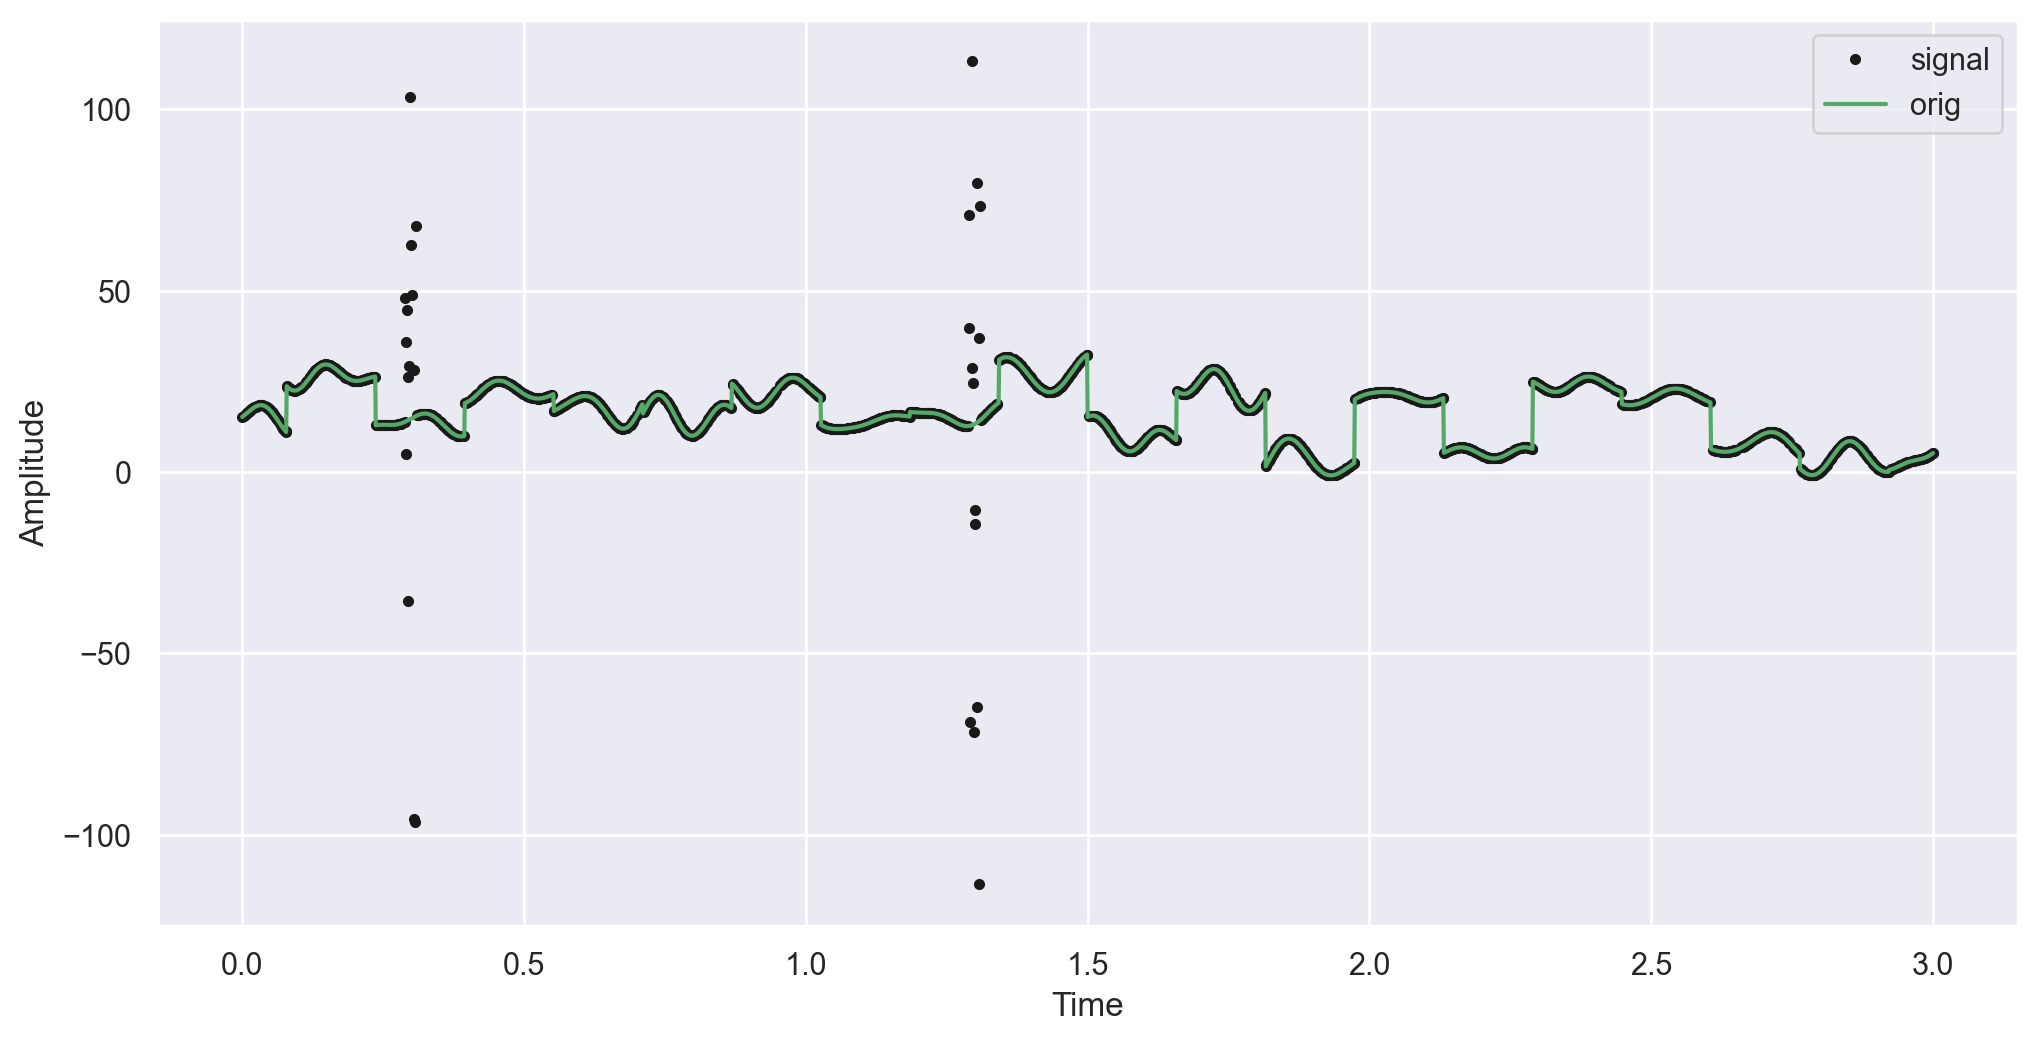

In [229]:
data = sio.loadmat('resample_code.mat')
origS = data['origS'].reshape(-1)
origT = data['origT'].reshape(-1)
signal = data['signal'].reshape(-1)
time = data['time'].reshape(-1)
time = time[np.where(np.logical_not(np.isnan(signal)))[0]]
signal = signal[np.where(np.logical_not(np.isnan(signal)))[0]]
plt.plot(time, signal, '.k', label='signal')
plt.plot(origT, origS, 'g', label='orig')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [230]:
is_continuous = lambda t, x: abs(x[1] + (x[1] - x[0]) / (t[1] - t[0]) * (t[2] - t[1]) - x[2]) \
                             < 0.10 * (t[2] - t[1]) / 0.001

In [231]:
gaps = np.array([0, 0], dtype=int).reshape(-1, 2)
gap_is_closed = True
for i in range(2, signal.size - 2):
    if is_continuous(time[i-2:i+1], signal[i-2:i+1]) or \
        is_continuous(time[i:i+3], signal[i:i+3]):
        gap_is_closed = True
        continue
    if gap_is_closed:
        gap_is_closed = False
        gaps = np.concatenate((gaps, np.array([i, i]).reshape(-1, 2)), axis=0)
    else:
        gaps[-1][1] = i+1
gaps = np.concatenate((gaps, np.array([-1, -1]).reshape(-1, 2)), axis=0)
new_time = np.arange(time[0], time[-1] + 1e-4, 1e-3)
new_gaps = np.zeros_like(gaps)
for i in range(gaps.shape[0]):
    for j in [0, 1]:
        new_gaps[i, j] = np.argmin(np.abs(new_time - time[gaps[i, j]]))

## Time to resample

In [232]:
new_signal = np.zeros_like(new_time)
for i in range(gaps.shape[0] - 1):
    i1, i2 = gaps[i, 1], gaps[i+1, 0]
    ni1, ni2 = new_gaps[i, 1], new_gaps[i+1, 0]
    new_signal[ni1:ni2] = griddata(time[i1:i2], signal[i1:i2], new_time[ni1:ni2], method='linear')
new_signal[-1] = signal[-1]
for l, r in new_gaps[1:-1]:
    fftPre = scipy.fftpack.fft(new_signal[2*l-r:l])
    fftPst = scipy.fftpack.fft(new_signal[r:2*r - l])
    
    mixeddata = scipy.signal.detrend( np.real(scipy.fftpack.ifft( ( fftPre+fftPst )/2 )))
    linedata  = np.linspace(0,1,r - l) * (new_signal[r]-new_signal[l-1]) + new_signal[l-1]
    linterp = mixeddata + linedata
    
    new_signal[l:r] = linterp

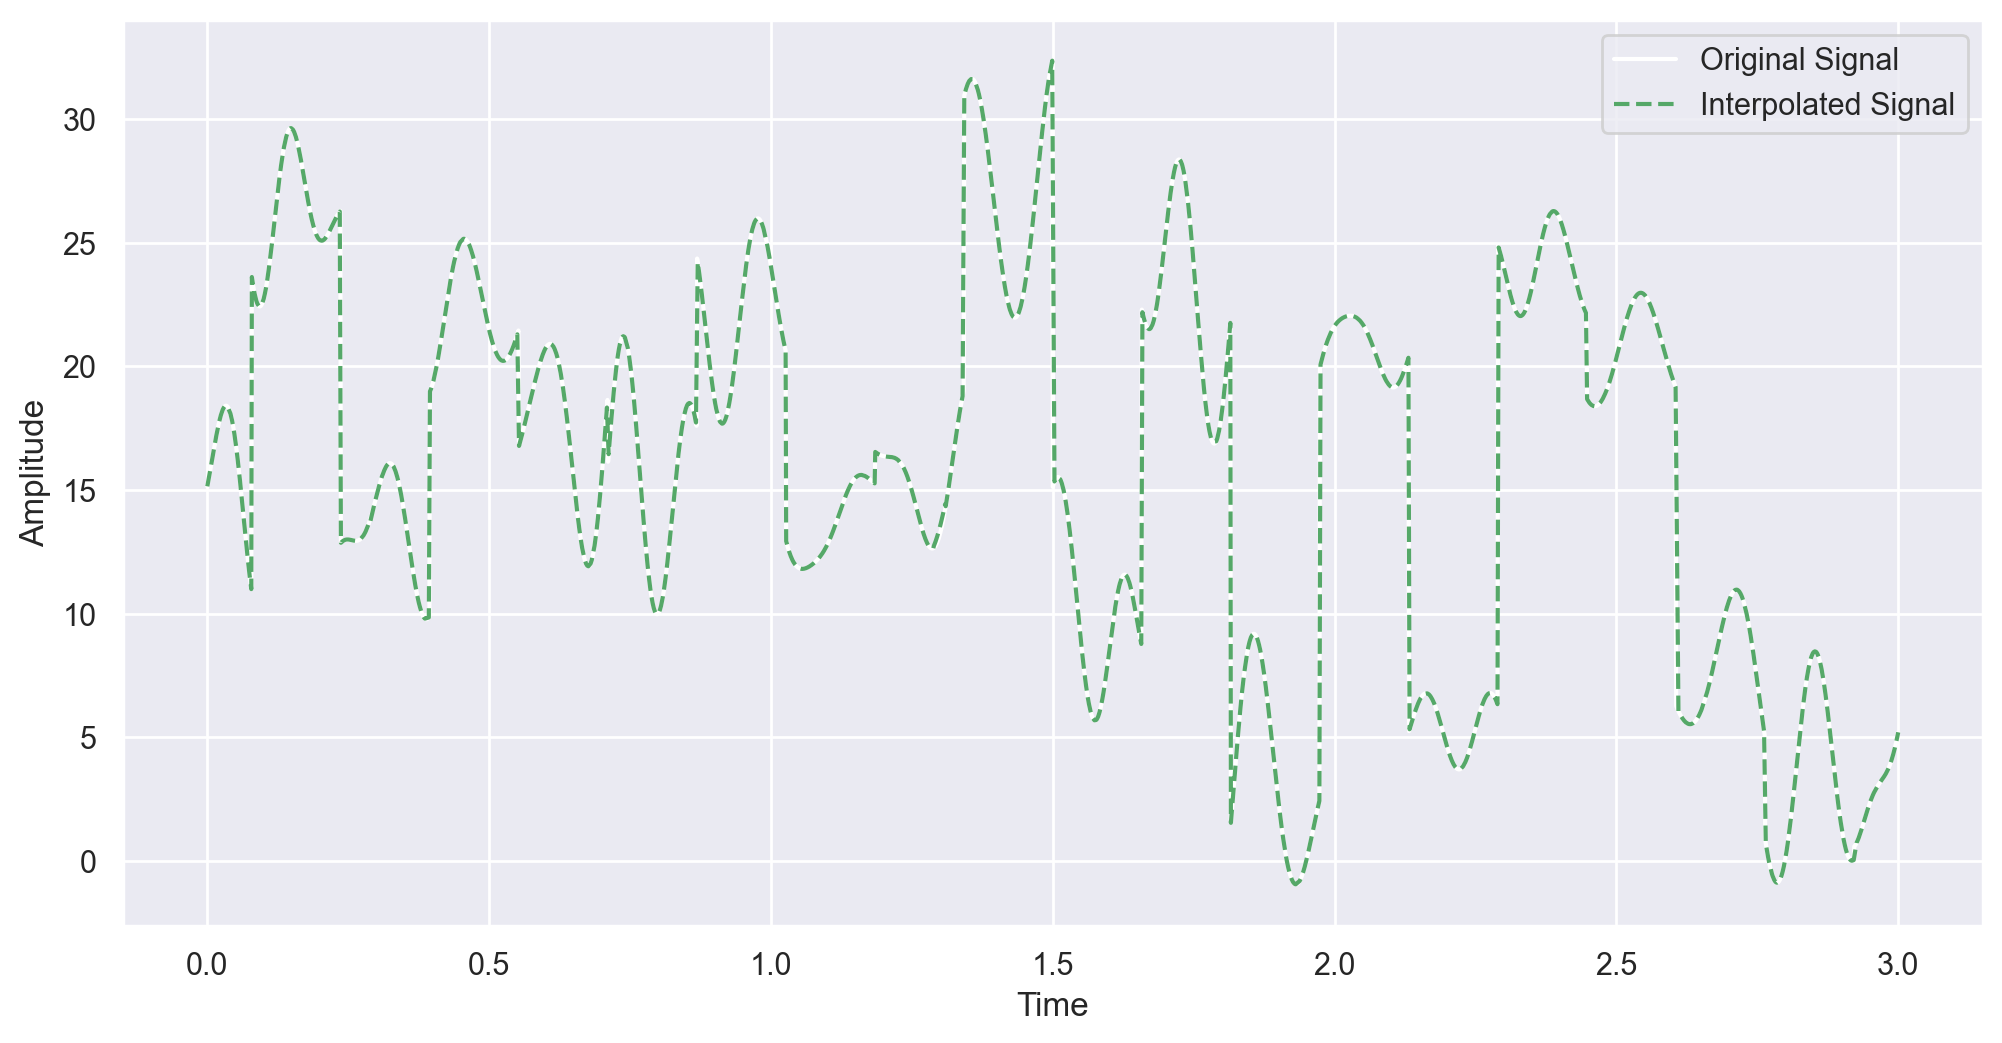

In [233]:
plt.plot(origT, origS, '-w', label='Original Signal')
plt.plot(new_time, new_signal, '--g', label='Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()